Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 4_Dogs vs Cats Image Classification Without Image Augmentation

We'll build an image classifier using tf.keras.Sequential model and load data using tf.keras.preprocessing.image.ImageDataGenerator.

#### Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

- Building data input pipelines using the tf.keras.preprocessing.image.ImageDataGenerator class — How can we efficiently work with data on disk to interface with our model?
- Overfitting - what is it, how to identify it?

#### Import packages

In [2]:
import tensorflow as tf 

from tensorflow.keras.preprocessing.image import ImageDataGenerator    

import os
import matplotlib.pyplot as plt
import numpy as np
     
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of Dogs vs. Cats dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
print(zip_dir)

C:\Users\ih371\.keras\datasets\cats_and_dogs_filterted.zip


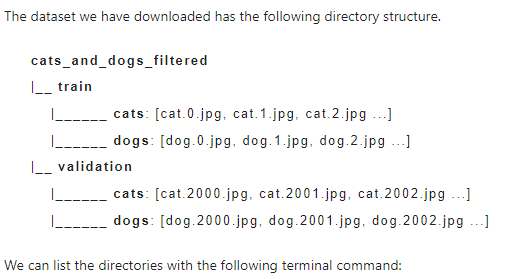

In [4]:
zip_dir_base = os.path.dirname(zip_dir)
print(zip_dir_base)


C:\Users\ih371\.keras\datasets


In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

#### Understanding our data
Let's look at how many cats and dogs images we have in our training and validation directory

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


#### Setting Model Parameters
For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [8]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

#### Data Preparation
Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. 

The steps involved in preparing these images are:
- Read images from the disk
- Decode contents of these images and convert it into proper grid format as per their RGB content
- Convert them into floating point tensors
- Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class tf.keras.preprocessing.image.ImageDataGenerator.

We can set this up in a couple of lines of code.

In [9]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [40]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


#### Model Creation
##### Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

Here's how softmax is used with convolutional neural networks (CNNs):

Convolutional Layers:

- Convolutional layers in CNNs extract features from image data using learnable filters. These features can represent edges, shapes, textures, and other patterns relevant to the classification task.
- The output of a convolutional layer is typically a multi-dimensional tensor with spatial dimensions (height and width) and a number of channels representing the extracted features.

Softmax Function:

- The softmax function is a mathematical operation that takes a vector of real numbers as input and converts it into a probability distribution. Each element in the output vector represents the probability of the input belonging to a specific class.
- In Keras, the softmax function is usually implemented as a separate layer following the convolutional layers.

Classification with Softmax:

- Flatten Layer (Optional): After the convolutional layers, a Flatten layer might be used to convert the multi-dimensional feature map from the convolutional layers into a one-dimensional vector. This is because the softmax function typically operates on vectors.
- Dense Layer: A fully-connected (dense) layer is often added after the convolutional layers (and optional flattening layer). This dense layer takes the flattened features and learns a mapping to the class probabilities.
- Softmax Layer: The softmax layer is applied to the output of the dense layer. It transforms the output vector from the dense layer (containing logits or activation values) into a probability distribution for each class. The resulting vector will have one element for each class, and the sum of all elements will be 1.

Example:

Imagine a CNN classifying images of handwritten digits (0-9). After the convolutional layers and any necessary flattening, the dense layer might output a vector with 10 elements (one for each digit class). The softmax layer would then convert these elements into probabilities, ensuring each value is between 0 and 1, and the sum of all probabilities is 1. The highest probability in the output vector would indicate the predicted class (the digit the model believes the image represents).

Key Points:

- Softmax provides a probabilistic interpretation for the output of a CNN in multi-class classification tasks.
- It's a separate layer typically applied after the feature extraction stages (convolutional layers) and any necessary dense layers.
- The softmax function doesn't directly affect the feature extraction process within the convolutional layers themselves.

In [12]:
model = tf.keras.models.Sequential([ #Sequential model, linear stack of layers, output is fed into next input
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    #32 = number of filters in layer, used to learn patterns in data
    #(3,3) - size of kernel, filter will look at 3x3 size at a time
    #activation='relu': This specifies the activation function applied to the output of the convolution operation. ReLU (Rectified Linear Unit) is a popular choice that introduces non-linearity.
    #input = only used in first layer, expects input of 150x150 pixel with 3 color channel RGB
    tf.keras.layers.MaxPooling2D(2, 2),
    #maxpool layers = downsampling by reducing spatial dimension of the feature maps, (2,2) specify the pooling size, almost similar to kernel size in terms of size of selection but purpose is different
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #these are additional convoluted layers with different filter size
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(), #This line adds a Flatten layer. This layer reshapes the multi-dimensional feature maps from the convolutional layers into a single one-dimensional vector. This is necessary before feeding the features into a fully-connected layer.
    tf.keras.layers.Dense(512, activation='relu'), #This line defines a fully-connected (dense) layer. This layer takes the flattened features from the previous layer and performs a linear transformation to learn a more complex representation of the data.
    tf.keras.layers.Dense(2, activation=tf.nn.softmax) #This line defines the final output layer of the CNN. This is another dense layer with two neurons. The number of neurons (2) typically corresponds to the number of classes you're trying to predict in a classification task.
])

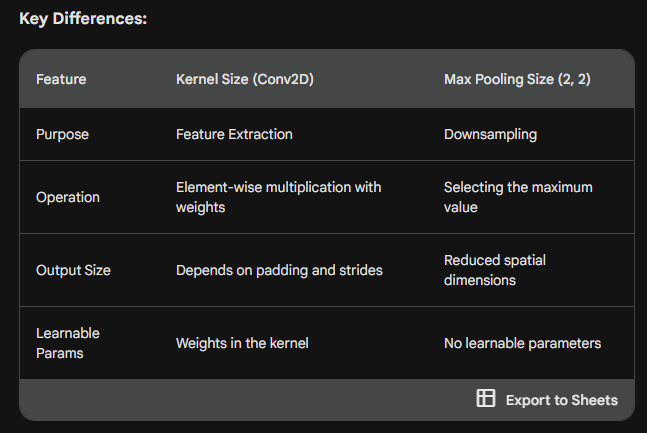

Determining the ideal kernel size and max pool size for your CNN architecture is an art and science, often involving experimentation and fine-tuning based on your specific dataset and task. Here are some general guidelines and factors to consider:

Kernel Size:

- Common Choices: Popular choices for kernel sizes in convolutional layers include 3x3, 5x5, and 7x7. These sizes have been shown to work well in various image recognition tasks.
- Smaller vs. Larger Kernels:
    - Smaller kernels (e.g., 3x3): Can be good for capturing local features and edges. They might be efficient for smaller images or for early layers in a CNN where you want to learn low-level features.
    - Larger kernels (e.g., 5x5 or 7x7): Can capture more complex patterns and might be suitable for later layers in the network or for tasks requiring identification of larger objects within the image.
- Task-Specific Considerations: The optimal kernel size can depend on the specific task. For example, in tasks requiring fine-grained details (e.g., facial recognition), smaller kernels might be preferred in earlier layers to capture those details.
- Experimentation: It's often beneficial to experiment with different kernel sizes to see what performs best for your dataset and task. You can train the model with various kernel sizes and compare the results (accuracy, loss, etc.).

Max Pooling Size:

- Downsampling and Feature Selection: The primary purpose of max pooling is to reduce the dimensionality of feature maps and potentially improve the model's ability to generalize by focusing on more robust features.
- Common Choices: A typical choice for max pooling size is 2x2, which halves the height and width of the feature maps.
- Stride: The stride parameter in max pooling layers also affects the output size. A stride of 2 with a pooling size of 2x2 will result in a 75% reduction in spatial dimensions.
- Balancing Downsampling and Information Loss: Excessive downsampling through large max pooling sizes can lead to information loss. It's important to strike a balance between reducing data size and preserving essential features.
- Experimentation: Similar to kernel size, try training your model with different max pooling sizes and strides to see how it affects performance.

Additional Tips:

- Start with Common Configurations: Begin with commonly used configurations like 3x3 kernel size and 2x2 max pooling with stride 2.
- Consider Hierarchy: As you stack convolutional layers, you might use smaller kernel sizes in earlier layers for basic feature extraction and gradually increase kernel size in later layers to capture more complex features.
- Computational Efficiency: Larger kernel sizes and pooling layers with smaller strides can increase computational cost. Consider this factor if you have resource constraints.
- Regularization: Techniques like dropout can help reduce overfitting, which might be more crucial when using larger kernel sizes.

Remember, the best kernel size and max pool size combination will depend on your specific problem, dataset size, and computational resources. Experimentation and evaluation are key to finding the optimal configuration for your CNN architecture.

#### Compile the model
As usual, we will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

: 

#### Model Summary
Let's look at all the layers of our network using summary method.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

#### Train the model
It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [15]:
EPOCHS = 20
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

C:\Users\ih371\AppData\Local\Temp\ipykernel_11820\2656592547.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20


c:\Users\ih371\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - 17s 819ms/step - loss: 0.7075 - accuracy: 0.4985 - val_loss: 0.6915 - val_accuracy: 0.5320
Epoch 2/20
20/20 [==============================] - 8s 379ms/step - loss: 0.6920 - accuracy: 0.5420 - val_loss: 0.6896 - val_accuracy: 0.5100
Epoch 3/20
20/20 [==============================] - 7s 371ms/step - loss: 0.6753 - accuracy: 0.5575 - val_loss: 0.6352 - val_accuracy: 0.6360
Epoch 4/20
20/20 [==============================] - 8s 395ms/step - loss: 0.6844 - accuracy: 0.5625 - val_loss: 0.6665 - val_accuracy: 0.6250
Epoch 5/20
20/20 [==============================] - 8s 387ms/step - loss: 0.6467 - accuracy: 0.5990 - val_loss: 0.6356 - val_accuracy: 0.6490
Epoch 6/20
20/20 [==============================] - 8s 395ms/step - loss: 0.5929 - accuracy: 0.6925 - val_loss: 0.5813 - val_accuracy: 0.6820
Epoch 7/20
20/20 [==============================] - 8s 391ms/step - loss: 0.5418 - accuracy: 0.7275 - val_loss: 0.5823 - val_accuracy: 0.6880
Epoch 8/20
20/20

We can see our training accuracy and loss starts to diverge from the validation set around epoch 9-10. Thus, showing some signs of overfitting.

#### Visualizing results of the training
We'll now visualize the results we get after training our network.

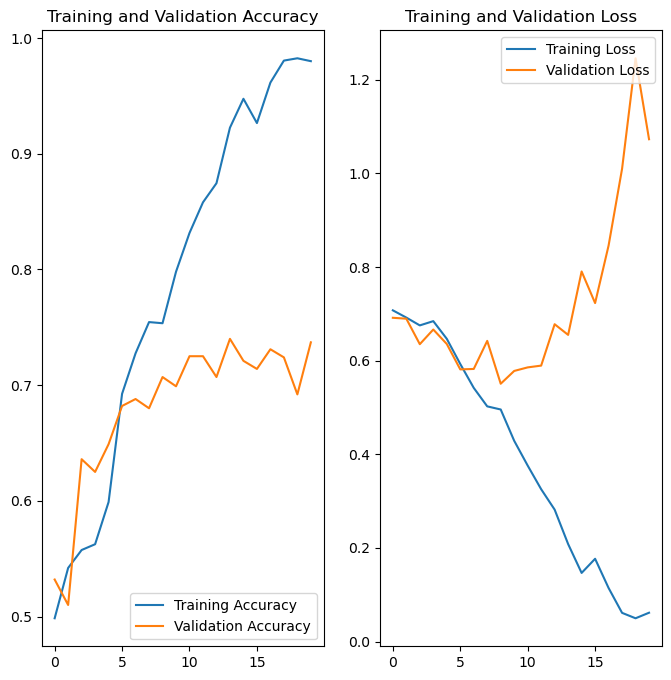

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

Here are some key methods to identify overfitting in your machine learning model, particularly when using Keras:

1. Monitor Training and Validation Loss:

- Overfitting often manifests as a significant gap between the training loss and validation loss.
- During training, the model optimizes for the training data, and the loss typically decreases.
- However, with overfitting, the model starts memorizing the training data instead of learning general patterns. This leads to a much lower training loss compared to the validation loss.
- In Keras, you can monitor both losses using the model.fit function with the validation_data argument:
- Python: history = model.fit(..., validation_data=(X_val, y_val))
- Plot the training and validation loss curves. If the training loss keeps decreasing significantly while the validation loss starts increasing or plateaus, it's a sign of overfitting.

2. Evaluate on Unseen Data:

- A good practice is to hold out a separate test set of data that the model has never seen during training.
- Evaluate the model's performance on this test set. A significant drop in accuracy compared to the validation set suggests overfitting.

3. Use Early Stopping:

- Keras provides the EarlyStopping callback that can help prevent overfitting.
- This callback monitors the validation loss and stops training if the validation loss fails to improve for a certain number of epochs (iterations).
- This helps prevent the model from continuing to train on data it's already memorized.

4. Analyze Learning Curves:

- Learning curves visualize the model's performance (loss or accuracy) on both training and validation data with increasing training size (number of epochs).
- In overfitting cases, the training accuracy might keep increasing even as the validation accuracy stagnates or decreases. This indicates the model is not generalizing well.

5. Regularization Techniques:

- Techniques like L1/L2 regularization (weight decay) or dropout layers can help reduce overfitting by penalizing large weights and promoting sparsity in the model.
- These techniques can make the model less prone to memorizing specific training examples and encourage learning more generalizable patterns.

Additional Tips:

- Data Augmentation: For image classification tasks, consider data augmentation techniques (random flips, rotations, etc.) to artificially increase the size and diversity of your training data, making it harder for the model to overfit.
- Reduce Model Complexity: If overfitting persists, try reducing the model's complexity (number of layers, neurons) to make it less flexible and less likely to memorize noise in the data.

By employing these methods and understanding the behavior of training and validation loss, you can effectively identify and address overfitting in your Keras models. Remember, the goal is to achieve a balance between fitting the training data well and generalizing well to unseen data.

#### Trying the Predictor

1/1 [==============================] - 0s 15ms/step


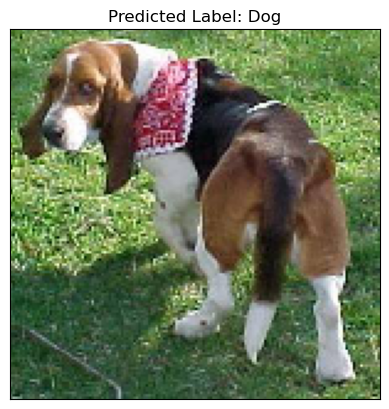

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single batch of data
data, labels = next(val_data_gen)

first_image = data[0]  # Assuming the first image in the batch

# Make prediction on the first image
predictions = model.predict(np.expand_dims(first_image, axis=0))

# Decode the label
class_names = ['Cat','Dog']  # Replace with your class names
predicted_class = np.argmax(predictions[0])  # Index of the maximum value
predicted_label_text = class_names[predicted_class]

# Rescale the image data to a range of 0-1 for visualization
if np.max(first_image) > 1:
  first_image = first_image / 255.0  # Assuming image data is in range 0-255

# Plot the image
plt.imshow(first_image)
plt.title("Predicted Label: " + predicted_label_text)
plt.xticks([])
plt.yticks([])
plt.show()

1/1 [==============================] - 0s 17ms/step
[0.00159674 0.99840325]
1/1 [==============================] - 0s 16ms/step
[0.6084142 0.3915858]
1/1 [==============================] - 0s 16ms/step
[0.03489048 0.96510947]
1/1 [==============================] - 0s 15ms/step
[9.999770e-01 2.300967e-05]
1/1 [==============================] - 0s 16ms/step
[0.99606884 0.0039312 ]
1/1 [==============================] - 0s 17ms/step
[0.13120665 0.8687933 ]
1/1 [==============================] - 0s 18ms/step
[0.06297846 0.9370216 ]
1/1 [==============================] - 0s 16ms/step
[0.99750704 0.00249294]
1/1 [==============================] - 0s 16ms/step
[9.9914956e-01 8.5042621e-04]
1/1 [==============================] - 0s 15ms/step
[3.5888833e-04 9.9964106e-01]


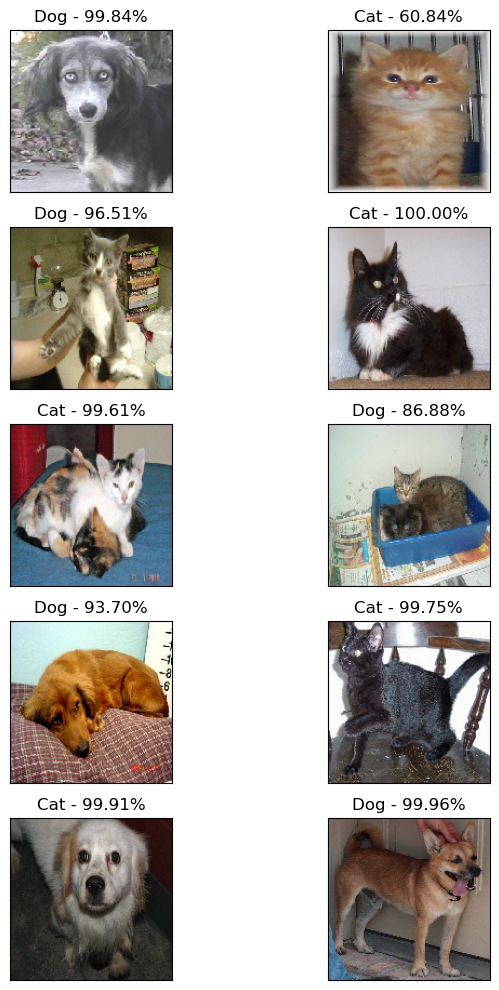

In [41]:
# Get a batch of data
data, labels = next(val_data_gen)

num_images = 10  # Number of images to display
plt.figure(figsize=(8, 10))
# Loop through the first 10 images in the batch
for i in range(min(num_images, len(data))):
  current_image = data[i]
  current_label = labels[i]

  # Make prediction on the current image
  predictions = model.predict(np.expand_dims(current_image, axis=0))

  # Decode the one-hot encoded label and get confidence
  class_names = ['Cat', 'Dog']
  predicted_class = np.argmax(predictions[0])
  predicted_label_text = class_names[predicted_class]
  confidence = np.max(predictions[0]) * 100  # Convert confidence to percentage
  print(predictions[0])
  # Rescale the image data to a range of 0-1 for visualization
  if np.max(current_image) > 1:
    current_image = current_image / 255.0

  # Create a subplot and display the image with label and confidence
  plt.subplot(5, 2, i + 1)  # Arrange images in a 5x2 grid
  plt.imshow(current_image)
  plt.title(f"{predicted_label_text} - {confidence:.2f}%")  # Display label and confidence
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)  # Remove grid lines for better visualization

# Ensure the plot is displayed even if less than 10 images are available
plt.tight_layout()
plt.show()